In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-darkgrid')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [2]:
df1 = pd.read_excel('/Users/christianhellum/Cand. Merc./Data-Science-Project/data_science_project/Praktik/data_final.xlsx')

In [10]:
df = df1.copy()
#drop missing data
df = df.dropna()

In [11]:
# Initially include all rows
df["Include"] = True

# Function to tag rows based on conditions
def tag_abnormal_values(df, condition, include_col='Include'):
    """
    Updates the Include column to False for rows that satisfy the given condition.

    :param df: The DataFrame to modify.
    :param condition: A condition (boolean array or series) for abnormal values.
    :param include_col: The column name to update for inclusion.
    :return: Modified DataFrame with updated Include column.
    """
    df.loc[condition, include_col] = False
    return df

# Define conditions for abnormality
conditions = [
    (df['energy_total'] < 1) | (df['energy_total'] > 2800)
]

# Exclude abnormal features
for condition in conditions:
    df = tag_abnormal_values(df, condition)
# Cut out all abnormal values
df = df[df.Include].drop(["Include"], axis=1)

#delete columns 'dhi', 'dni', 'precip', 'snow', 'wind_spd'
df = df.drop(['dhi', 'dni', 'precip', 'snow', 'wind_spd'], axis=1)

#extract the hour from the datetime column
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

#only keep rows where hour is between 8 and 18
df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
#delete three first rows
df = df.iloc[3:]

#drop hour column
df = df.drop(['hour'], axis=1)
df = df.drop(['hour_nr'], axis=1)
df = df.drop(['day_of_year'], axis=1)
df = df.drop(['month_nr'], axis=1)

#start the data from date 2022-03-30 08:00:00
df = df[df['datetime'] >= '2022-03-30 08:00:00']

#delete energy_total in df
df = df.drop(columns=['datetime'], axis=1)

#drop missing data
df = df.dropna()

In [12]:
df = df.apply(pd.to_numeric, errors='coerce')

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.75)]
val_df = df[int(n*0.75):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)

Training set shape: (7322, 18)
Validation set shape: (1464, 18)
Test set shape: (977, 18)


In [14]:
# Calculate mean and standard deviation for all features except 'energy_total'
features_to_scale = [col for col in train_df.columns if col != 'energy_total']
train_mean = train_df[features_to_scale].mean()
train_std = train_df[features_to_scale].std()

# Scale the selected features
train_df[features_to_scale] = (train_df[features_to_scale] - train_mean) / train_std
val_df[features_to_scale] = (val_df[features_to_scale] - train_mean) / train_std
test_df[features_to_scale] = (test_df[features_to_scale] - train_mean) / train_std

/var/folders/8l/n92rnf315xdf87gkyx0s1n840000gn/T/ipykernel_6367/1594022742.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8l/n92rnf315xdf87gkyx0s1n840000gn/T/ipykernel_6367/1594022742.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8l/n92rnf315xdf87gkyx0s1n840000gn/T/ipykernel_6367/1594022742.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Setting a random seed for reproducability

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
df.head()

,clouds,ghi,pres,slp,solar_rad,temp,uv,energy_total,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,sine_elevation,cosine_elevation,sine_azimuth,cosine_azimuth
119,100,373,1005,1008,122,0.7,1.0,187.80,1.0,6.123234e-17,0.99925,0.038722,-9.510565e-01,0.309017,0.406737,0.913545,0.852640,-0.522499
120,100,489,1005,1008,144,2.7,1.5,223.32,1.0,6.123234e-17,0.99925,0.038722,-5.877853e-01,0.809017,0.509041,0.860742,0.685818,-0.727773
121,100,572,1005,1008,158,2.8,1.6,500.56,1.0,6.123234e-17,0.99925,0.038722,-2.449294e-16,1.000000,0.579281,0.815128,0.444635,-0.895712
122,100,614,1005,1008,165,2.8,1.7,465.32,1.0,6.123234e-17,0.99925,0.038722,5.877853e-01,0.809017,0.614285,0.789084,0.139173,-0.990268
123,100,610,1005,1008,165,1.7,1.5,371.12,1.0,6.123234e-17,0.99925,0.038722,9.510565e-01,0.309017,0.611527,0.791224,-0.190809,-0.981627


In [77]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [78]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [79]:
def plot(self, model=None, plot_col='energy_total', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} KWh')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Tid i timer')

WindowGenerator.plot = plot

In [80]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [81]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [109]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 40
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39]
Label column name(s): None

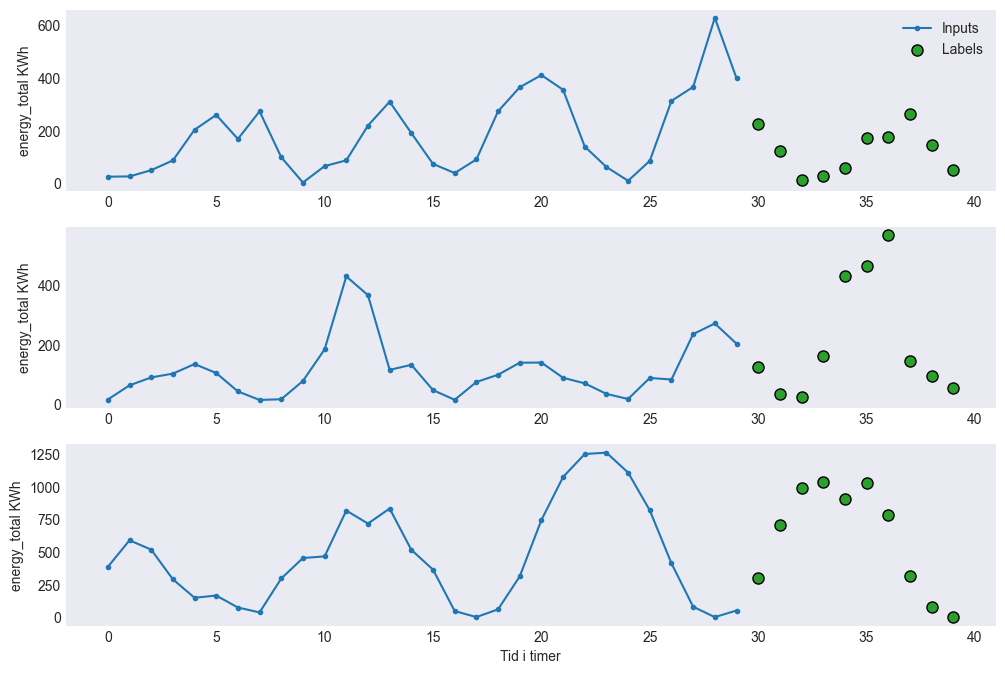

In [116]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

45/45 [==============================] - 0s 1ms/step - loss: 29315.6797 - mean_absolute_error: 32.6723


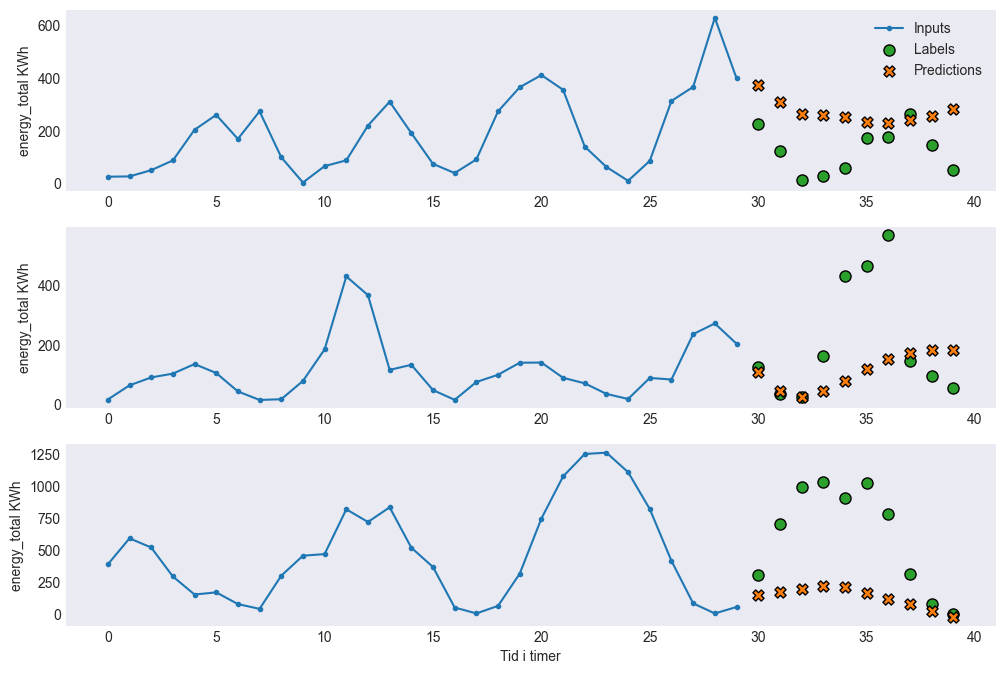

In [117]:
multi_val_performance = {}
multi_performance = {}

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

45/45 [==============================] - 0s 2ms/step - loss: 18354.8906 - mean_absolute_error: 26.4946


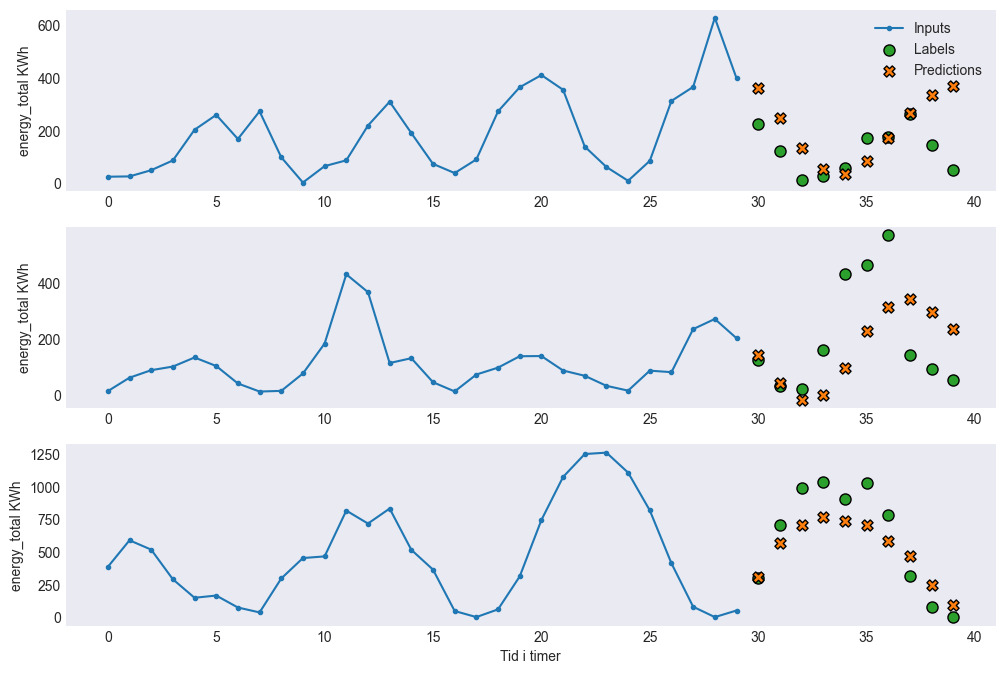

In [118]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

45/45 [==============================] - 0s 2ms/step - loss: 18416.9531 - mean_absolute_error: 28.2355


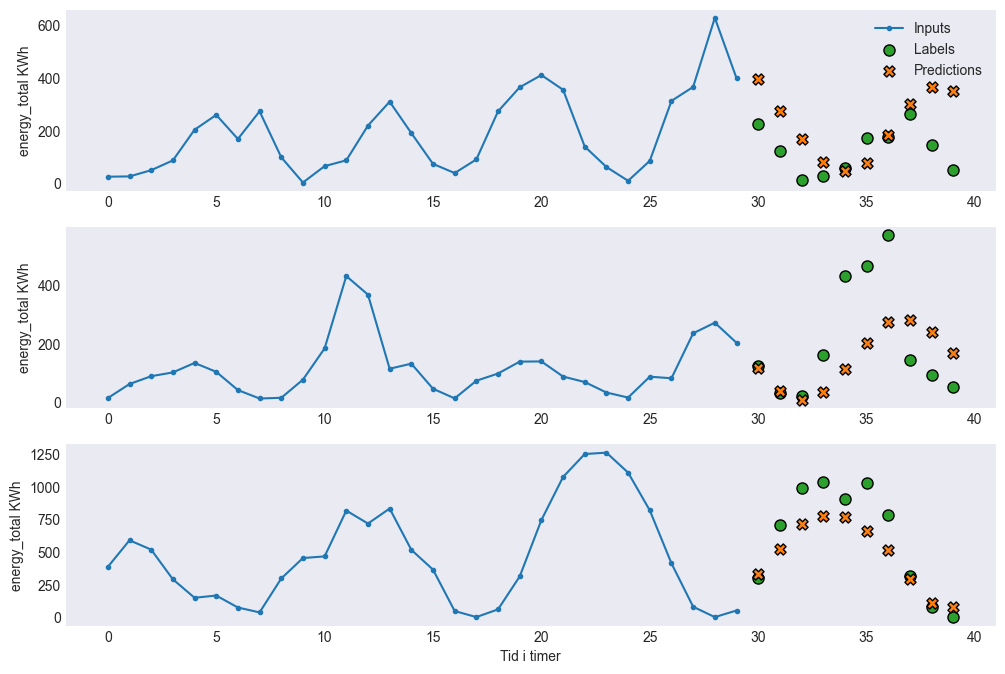

In [119]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)